# The Fairy Network!

One of the most beloved cartoons of the last couple of decades is the Fairly Odd Parents. This show follows the adventures of Timmy Turner, your regular 10 year old kid, and his fairy godparents, Cosmo and Wanda, who grant most of his wishes using their magic. The storyline of the majority of episodes revolves around a particular wish Timmy asks for, leading to unexpected and humorous consequences. Something that characterized the show in my opinion was the wide variety of relevant and amusing characters that make up the "Fairly OddParents Universe", even just considering season 1. 

Because of this I thought it would be interesting to build a network between these characters the connected them in a meaningful way. I had seen this done for novels using proximity within the text; if character A and character B were not that far apart in the text, they would become connected. I figured I could do something similar using the transcript of the show, however a much better idea came to mind ones I saw one of the transcripts in the Fairly OddParents Fandom wiki: since transcripts are esentially dialogues of the characters, I could use this to determine when a particular character referenced another one, or roughly speaking when two characters are talking to each other.

The following code aims to build a network through this heuristic using all episodes of the first season of the show. Moreover, once the network is constructed, we will perform some network analysis to explore how rich the structure becomes by using the rule of connectivity and to see if there are interesting conclusions that might be under the surface. 

In [1]:
import pandas as pd
import itertools
from pyvis import network as net
from pyvis.network import Network
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm

## Importing and Cleaning the Data
First of all, as I mentioned before, we used transcripts in .txt files obtained through the Fandom wiki page. Fortunately, because of the way the transcripts are written, every dialogue is written in a single line. Therefore, we read the file line by line to get the dialogues.

In [2]:
Transcripts = {}
for i in range(1,15):
    with open(f"Transcripts/Episode {i}.txt", "r", encoding= "ISO-8859-1") as file:
        try:
            Transcripts["Episode " + f"{i}"] = file.readlines()
        except UnicodeDecodeError:
            print(f"Decoding error in Episode {i}")


# Note: Episodes 13 and 14 couldn't be read due to decoding issues 
# under the standard encoding UTF-8. Encoding ISO-8859-1 which is also
# common seemed to work properly.
 

In [3]:
Transcripts["Episode 1"][0:5]

['(Bugle playing Reveille is heard; Timmy is asleep, snoring; camera points to Cosmo and Wanda in fish form)\n',
 'Wanda: Ready, Cosmo?\n',
 'Cosmo: Ready, Wanda.\n',
 'Cosmo and Wanda: 1, (turn to their fairy form) 2, 3!\n',
 'Cosmo: (flies near Timmy) Wakey-wakey, Timmy!\n']

 However, as we can see, it is important to note that a line may not be a dialogue but a scene description, which for our purposes is not very descpritive. In other cases dialogues may have scene descriptions inside of them, meaning that just because a name is present in a line doesn't mean that somebody is actually referring to that character. For the sake of simplicity, in all of the following scene descriptions inside a dialog WILL be considered as references. 

 We will now strip all those lines that describe a scene from the transcripts. A quick inspection suggests that such lines begin either with a parenthesis or a square bracket. Thus if a line satisfies this condition it will be discarded from the transcript.

In [4]:
for i in range(1,15):
    for line in Transcripts[f"Episode {i}"]:
        if line[0] == "(":
            Transcripts[f"Episode {i}"].remove(line)
        elif line[0] == "[":
            Transcripts[f"Episode {i}"].remove(line)

Transcripts["Episode 1"][0:5]

['Wanda: Ready, Cosmo?\n',
 'Cosmo: Ready, Wanda.\n',
 'Cosmo and Wanda: 1, (turn to their fairy form) 2, 3!\n',
 'Cosmo: (flies near Timmy) Wakey-wakey, Timmy!\n',
 "Wanda: Oh, come on, little fella, even though we're your (lifts Timmy up in the air with her wand) fairy godparents...\n"]

This is all the preprocessing we can do at the moment. However, as we will see later, considerations and manipulations have to be made regarding the format of the transcripts in order to properly define the connections through character referencing, and also to build a meaningful network of characters.

## Creating the Network

### Nodes
First we need to find all the potential nodes for the network, and to do so we have to keep the following in mind:

 - There will be dialogues of unimportant characters which we don't want to take into account.
 - Some characters may have more than one way to refer to them (e.g. Mr. Turner is called "Dad" by Timmy)
 - Coupled with the previous one, there may be inconsistencies in the way characters are referred to 
by the writers between episodes.

In order to get all the possible candidates for nodes, notice that every line that corresponds to a dialogue starts with the name of the character that speaks, followed by a colon, and then the actual dialogue. We will use this to find all potential characters.

In [5]:
# Find the first instance of a colon (":") and everything before it is the speaker.
def Retrieve_speaker(dialogue):
    colon = dialogue.find(":")
    if colon != -1:
        character = dialogue[:colon]
    else:
        character = "No character" # in case it is not actually a dialog
    return character

# Find all speakers in an episode and save them in a list.
def Characters_in_episode(episode_num):
    episode = Transcripts["Episode " + str(episode_num)]
    characters = []
    for line in episode:
        speaker = Retrieve_speaker(line)
        if speaker not in characters:
            characters.append(speaker)
    return characters

print("This is the list of all preliminary characters appearing in episode 1")
Characters_in_episode(1)


This is the list of all preliminary characters appearing in episode 1


['Wanda',
 'Cosmo',
 'Cosmo and Wanda',
 'Timmy',
 'Francis',
 'Coach',
 '#0 Player',
 '#99 Player',
 'Timmy (1/4)',
 'No character',
 'Dad',
 'Mr. Turner',
 'Mom',
 'Vicky',
 'Old Lady',
 'A.J. and Chester',
 'Older Timmy',
 'Waiter',
 'Chester',
 'Messenger',
 'Kid',
 'Father',
 'Cop',
 'Prisoners',
 'Chester and AJ']

Now that we have found the list of speakers of every episode, we contruct a preliminary set of characters by taking the (set) union of such lists.

In [6]:
def Possible_Characters():
    characters = []
    for i in range(1,15):
        characters += Characters_in_episode(i)
    characters = list(set(characters)) # drop duplicate instances of characters
    return characters
characters_clean = Possible_Characters()
print("The number of preliminary characters is", len(characters_clean))

The number of preliminary characters is 162


As it can be seen, we may encounter issues like: unison dialogues (e.g "Cosmo and Wanda"), irrelevant characters (e.g. "Kid") or even nonsensical characters (there is an "All" somewhere in characters_clean),  all of which need to be handled. To attempt to do so in a mostly automated way, we will do this in two stages: a first general stage which will be done now, and a second stage later on dependent on the connections we will construct. 

For the first stage we will remove every character whose name has either the string "Kid" or "#" inside of it, since either one of these probably makes reference to an irrelevant character. Coupled with this, we will also remove strings that have conjunctions such as "and" and "&" to mitigate redundance.

In [7]:
unwanted_strings = ["#", "Kid", " and ", " & "]
characters_clean = [character for character in characters_clean if not
                     any(string in character for string in unwanted_strings)]

print("By doing this, the amount of characters has already dropped to", len(characters_clean), "characters")


By doing this, the amount of characters has already dropped to 123 characters


### Edges

As mentioned in the intro, the edges of the graph will be constructed through the reference of a character in the dialogue of another in hopes iof capturing the interaction of both characters. Specifically, an edge from node A to node B will be constructed when character A names character B in a dialogue. Edges will be weighted with the weights being the amount of such references made throughout each episode.

We will save these in a pandas Dataframe mimicking an edgelist instead of an adjacency matrix to disregard the anticipated number of nonexisting edges between different characters. We do this for every episode which in principle would allow us to create a network for each episode.

In [8]:
edges_clean = pd.DataFrame({"Character A": [], "Character B": []})
for i in range(1, 15):
    edges_clean[f"Weight Ep. {i}"] = []


def Edges_dialogue(dialogue):
    # Variables chars_A and chars_B below are lists of characters involved
    # in the dialogue. Notice that there may be more than one speaker
    # (unison dialogues) and more than one character referenced to 
    # in any dialogue. 
    chars_A = Retrieve_speaker(dialogue).replace(" & ", " and ") 
    chars_A = chars_A.split(" and ") # Split unison dialogues
    chars_A = [character for character in chars_A 
               if character in characters_clean] # Save speakers that are possible characters

    chars_B = [] 
    for character in characters_clean:
        if dialogue.find(character) != -1: # Check whether a possible character is present in the dialogue
            chars_B.append(character)

    if len(chars_B) > 0:
        edges = list(itertools.product(chars_A, chars_B)) # Construct all directed pairs
    else:
        edges = []
    return edges


def Edges_episode(episode_num):
    edges_ep = []
    for dialogue in Transcripts[f"Episode {episode_num}"]:
        edges_ep += Edges_dialogue(dialogue)
    return edges_ep

for i in range(1,15):
    for edge in Edges_episode(i):
        # First, check using a boolean mask whether a particular connection 
        # is already on the edges dataframe
        mask = (edges_clean["Character A"] == edge[0]) & (edges_clean["Character B"] == edge[1])
        if not edges_clean[mask].any(axis = None):
            # If it isn't, then add it to the df
            new_row = pd.DataFrame([{"Character A": edge[0], "Character B": edge[1],
                                      **{f"Weight Ep. {j}": 1 if j == i else 0 for j in range(1, 15)}}])
            edges_clean = pd.concat([edges_clean, new_row], ignore_index=True)
        else:
            # If it is, add to the weight of the particular episode
            edges_clean.loc[mask, f"Weight Ep. {i}"] += 1    


Self-references are usually uninteresing since they come from scene descriptions, not actual monologues, thus we rule those out. Moreover, we discard all connections involving the placeholder "No character" and add the weights of all episodes to create the "seasonal weight" of each connection. This process results in a dataframe with 273 connections for the network.

In [9]:
edges_clean = edges_clean.loc[edges_clean["Character A"] != edges_clean["Character B"]]
edges_clean = edges_clean.loc[(edges_clean["Character A"] != "No character") & (edges_clean["Character B"] != "No character")]
edges_clean["Weight Season"] = edges_clean.sum(numeric_only=True, axis = 1)
edges_clean.reset_index(drop= True, inplace= True)
edges_clean

,Character A,Character B,Weight Ep. 1,Weight Ep. 2,Weight Ep. 3,Weight Ep. 4,Weight Ep. 5,Weight Ep. 6,Weight Ep. 7,Weight Ep. 8,Weight Ep. 9,Weight Ep. 10,Weight Ep. 11,Weight Ep. 12,Weight Ep. 13,Weight Ep. 14,Weight Season
0,Wanda,Cosmo,7.0,6.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,11.0,2.0,2.0,2.0,1.0,46.0
1,Cosmo,Wanda,8.0,2.0,1.0,0.0,4.0,5.0,4.0,5.0,4.0,9.0,3.0,2.0,2.0,1.0,50.0
2,Cosmo,Timmy,6.0,1.0,4.0,2.0,2.0,11.0,5.0,4.0,1.0,2.0,5.0,6.0,3.0,1.0,53.0
3,Wanda,Timmy,10.0,6.0,1.0,2.0,0.0,11.0,6.0,4.0,2.0,1.0,4.0,9.0,4.0,4.0,64.0
4,Timmy (1/4),Timmy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,Maria,Santa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
269,Santa,Wanda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
270,Santa,Cosmo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
271,All Holiday mascots,All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


This is good enough to give a preliminary version of the network. Through the library pyvis we are able to create interactive visualizations built from network objects from Networkx. These network objects can be constructed in many ways, here we utilize the pandas edgelist above. This is so easy it is almost like magic, you've got you edge list and then POOF!... you have your network! Remember that the network is interactive, so make sure yo move it around to get a feeling of it.

In [10]:
G = nx.from_pandas_edgelist(edges_clean, "Character A", "Character B", "Weight Season")
nt = net.Network(notebook= True, cdn_resources='remote')
nt.from_nx(G)
nt.show("Fairy Network version 1.html")

Fairy Network version 1.html


At this moment we will carry on the second stage of handling cases of possible irrelevant characters through their connections. The heuristic behind the following procedure is that characters that have few and small-weighted connections are probably irrelevant, or at least not relevant enough. Because important characters may appear briefly in some episodes, we will use the "Weight Season" column to identify irrelevant characters in the abovementioned sense. 

Let us define a character as "weakly connected" if the sum of the "Weight Season" column, over all the edges the character is present, is less than 4 (so that the character had to be present in at least 4 dialogues throughout the season). Thus, this stage will consist in removing all edges involving weakly connected characters.

In [11]:
def Weakly_connected(character):
    relevance = edges_clean.loc[(edges_clean["Character A"] == character) 
                                | (edges_clean["Character B"] == character), "Weight Season"].sum()
    if relevance < 4: 
        return True
    else:
        return False
    
characters_clean = [character for character in characters_clean if not Weakly_connected(character)]
print("Now the number of characters has had a dramatic drop to", len(characters_clean), "characters")

Now the number of characters has had a dramatic drop to 51 characters


In [12]:
# Update the pandas edge dataframe considering only non-weakly connected characters
edges_clean = edges_clean.loc[(edges_clean["Character A"].isin(characters_clean)) & (edges_clean["Character B"].isin(characters_clean))]
edges_clean.reset_index(drop = True)

,Character A,Character B,Weight Ep. 1,Weight Ep. 2,Weight Ep. 3,Weight Ep. 4,Weight Ep. 5,Weight Ep. 6,Weight Ep. 7,Weight Ep. 8,Weight Ep. 9,Weight Ep. 10,Weight Ep. 11,Weight Ep. 12,Weight Ep. 13,Weight Ep. 14,Weight Season
0,Wanda,Cosmo,7.0,6.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,11.0,2.0,2.0,2.0,1.0,46.0
1,Cosmo,Wanda,8.0,2.0,1.0,0.0,4.0,5.0,4.0,5.0,4.0,9.0,3.0,2.0,2.0,1.0,50.0
2,Cosmo,Timmy,6.0,1.0,4.0,2.0,2.0,11.0,5.0,4.0,1.0,2.0,5.0,6.0,3.0,1.0,53.0
3,Wanda,Timmy,10.0,6.0,1.0,2.0,0.0,11.0,6.0,4.0,2.0,1.0,4.0,9.0,4.0,4.0,64.0
4,Timmy,All,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,The Easter Bunny,Cosmo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
200,The Easter Bunny,All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
201,Timmy,Star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
202,Santa,Wanda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


If we draw this refined network we can notice a huge difference done by ruling out weakly connected characters. And for those who have seen the show, this version is much closer to a network containing relevant characters in the series.

In [13]:
G = nx.from_pandas_edgelist(edges_clean, "Character A", "Character B", "Weight Season")
nt = net.Network(notebook= True, cdn_resources='remote')
nt.from_nx(G)

nt.show("Fairy Network version 2.html")

Fairy Network version 2.html


The number of possible relevant characters was reduced so dramatically that the amount of "outliers" is minimal, so much so that they can be handled case by case. Among these we note:

1) The characters "Man", "All", "TV" and "TV Narrator" may be removed.
2) The names "Chet", "Chet Ubetcha", "Chet Ubetcha (offscreen)" refer to the same character.
3) The names "A.J." and "AJ" refer to the same character.
4) The names "Mom" and "Mrs. Turner" refer to the same character.
5) The names "Dad" and "Mr. Turner" refer to the same character.

In [14]:
# 1) Remove irrelevant/nonsensical characters
for character in ["Man", "All", "TV", "TV Narrator"]:
    characters_clean.remove(character)

edges_clean = edges_clean.loc[(edges_clean["Character A"].isin(characters_clean)) & (edges_clean["Character B"].isin(characters_clean))]

# 2), 3), 4) and 5) Merge instances in the edge dataframe accordingly

# First define a mapping to replace the names in the dataframe
renaming = {character : character for character in characters_clean}
renaming["Chet"] = "Chet Ubetcha"
renaming["Chet Ubetcha (offscreen)"] = "Chet Ubetcha"
renaming["AJ"] = "A.J."
renaming["Mom"] = "Mrs. Turner"
renaming["Dad"] = "Mr. Turner"
characters_clean = list(set(list(renaming.values()))) # get all (unique) names of characters

# Next, use such mapping
edges_clean["Character A"] = edges_clean["Character A"].map(renaming)
edges_clean["Character B"] = edges_clean["Character B"].map(renaming)

# Because you may now have repeated connections, group by the pair of columns
# "Character A" and "Character B" , use the agg method to sum column by column
# and take into account the weights of both registries, and set the edges_dataframe
# as the output of this. 
edges_clean = edges_clean.groupby(["Character A", "Character B"], as_index= False).agg("sum")

# Remove possible references that could come up from this
edges_clean = edges_clean.loc[edges_clean["Character A"] != edges_clean["Character B"]]

In [15]:
G = nx.from_pandas_edgelist(edges_clean, "Character A", "Character B", "Weight Season")
nt = net.Network(notebook= True, cdn_resources='remote')
nt.from_nx(G)

nt.show("Fairy Network version 3.html")

Fairy Network version 3.html


The visual representation of the network suggests that Chet Ubetcha may have become a weakly connected character. This is confirmed through a quick check.

In [16]:
edges_clean[(edges_clean["Character A"] == "Chet Ubetcha") | (edges_clean["Character B"] == "Chet Ubetcha")]


,Character A,Character B,Weight Ep. 1,Weight Ep. 2,Weight Ep. 3,Weight Ep. 4,Weight Ep. 5,Weight Ep. 6,Weight Ep. 7,Weight Ep. 8,Weight Ep. 9,Weight Ep. 10,Weight Ep. 11,Weight Ep. 12,Weight Ep. 13,Weight Ep. 14,Weight Season
27,Chet Ubetcha,Santa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
28,Chet Ubetcha,Timmy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


 In principle, this could in turn make characters connected to Chet Ubetcha weakly connected and this could go on and on with characters connected to those characters. Luckily, from the visual representation of the network it is easy to see that neither Santa nor Timmy (obviously) become weakly connected. Furthermore, the same visual also tells that this does not happen with any of the changes made through the mapping above. So for the sake of consistency, we indeed remove the character. And with this, the list of relevant characters is polished.

In [17]:
characters_clean = [character for character in characters_clean if character != "Chet Ubetcha"]
edges_clean = edges_clean.loc[(edges_clean["Character A"].isin(characters_clean)) & (edges_clean["Character B"].isin(characters_clean))]
print("The final number of characters to be considered is", len(characters_clean))

The final number of characters to be considered is 41


Finally, we give the network a better format for visualization purposes.

In [18]:
# We add color to the edges
edges_clean["color"] = "#2ECCFA"

# We consider attributes of size, shape and color for the nodes
nodes_size = {character: np.max([edges_clean.loc[(edges_clean["Character A"] == character) |
                                   (edges_clean["Character B"] == character), "Weight Season"].sum() / 5, 5])
                                   for character in characters_clean}

nodes_shape = {character: "star" for character in characters_clean}
nodes_color = {character: "#F7FE2E" for character in characters_clean}
df_nodes = pd.DataFrame({character : {"shape" : nodes_shape[character], "size": nodes_size[character], 
                                      "color" : nodes_color[character]} for character in characters_clean})

# We review the attributes of Timmy, Wanda and Cosmo 
# because they are the most important characters
df_nodes["Timmy"].pop("shape") # keep a circular shape
df_nodes["Cosmo"].pop("shape") # keep a circular shape
df_nodes["Wanda"].pop("shape") # keep a circular shape
df_nodes["Timmy"]["color"] = "#FF0080"
df_nodes["Wanda"]["color"] = "#Fe2EC8"
df_nodes["Cosmo"]["color"] = "#04B404"

# Construct the graph object,add the node attributes to the graph and
# visualize it using pyvis.
G = nx.from_pandas_edgelist(edges_clean, source="Character A", target="Character B", edge_attr= ["Weight Season", "color"] )
nx.set_node_attributes(G, df_nodes)
nt = Network(height = "600px", width = "1200px" , bgcolor = "#9b56c0" , font_color = "white", notebook=True, cdn_resources= 'remote') 
nt.barnes_hut( gravity = -700)
nt.from_nx(G)
nt.show("Fairy Network season 1.html")

Fairy Network season 1.html


## Network Analysis
Now that we have constructed the network we will analyze it through some descriptive statistics, centrality measures and a community detection algorithm. 

For starters, we plot the degree distribution of the graph. (*Appreciation pause for the magic wand histogram*)

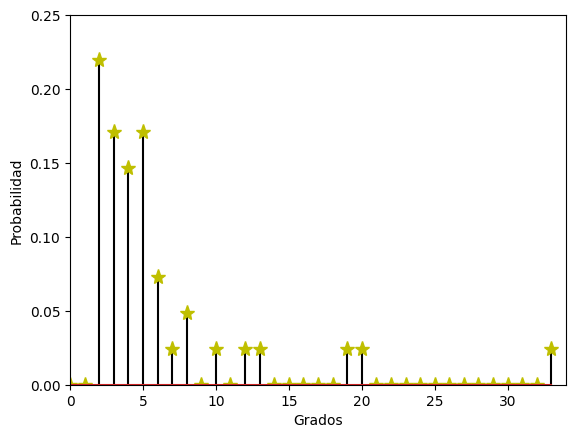

In [19]:
weight_columns = edges_clean.drop(["color"], axis= 1)
outdegree_dist = weight_columns.groupby("Character A", as_index = False).agg("sum").drop(["Character B"], axis = 1)
indegree_dist = weight_columns.groupby("Character B", as_index = False).agg("sum").drop(["Character A"], axis = 1)

degree_histogram = nx.degree_histogram(G)
degree_histogram = [degree / sum(degree_histogram) for degree in degree_histogram] 
fig, ax = plt.subplots()
markerline = ax.stem(np.arange(len(degree_histogram)), degree_histogram, linefmt = 'black', markerfmt='*y')[0]
ax.set(xlim = [0, len(degree_histogram)], ylim=[0,0.25])
plt.setp(markerline, markersize = "11")
plt.xlabel('Grados')
plt.ylabel('Probabilidad')
plt.show()

The distribution seems to follow a power-law distribution which is one of the most common patterns in graph applications; most nodes are of low degree and as the degree increases the fewer the nodes with such degree. Moreover, there is a single character (Timmy) with a much higher degree than the rest of the characters in the network, which is again something relatively common in applications. In fact, this behaviour coupled with Cosmo and Wanda having a much higher degree than other characters is to be expected as they are the true main characters of the show.

Through the use of some centrality measures we are able to give some insight in the connections that arise through the network.

In [20]:
characters_clean = pd.Series(characters_clean)
Centralities = pd.DataFrame({})
Centralities["Character"] = characters_clean
Centralities["Degree"] = Centralities["Character"].map(nx.degree_centrality(G))
Centralities["Betweenness"] = Centralities["Character"].map(nx.betweenness_centrality(G))
Centralities["Eigenvector"] = Centralities["Character"].map(nx.eigenvector_centrality(G, weight= "Weight Season"))
Centralities["Clustering"] = Centralities["Character"].map(nx.clustering(G, weight= "Weight Season"))


Centralities.sort_values(by = "Degree", ascending= False, inplace= True, ignore_index= True)
Centralities

,Character,Degree,Betweenness,Eigenvector,Clustering
0,Timmy,0.825,0.552711,0.598210,0.012251
1,Cosmo,0.500,0.126428,0.483495,0.020458
2,Wanda,0.475,0.100363,0.572890,0.024057
3,Chester,0.325,0.048922,0.065384,0.016867
4,Vicky,0.300,0.028432,0.124998,0.025766
5,A.J.,0.250,0.026654,0.060256,0.025404
6,Mrs. Turner,0.200,0.034721,0.088307,0.025281
7,Mr. Turner,0.200,0.028781,0.109217,0.043050
8,Cupid,0.175,0.006962,0.018027,0.019139
9,Crimson Chin,0.150,0.099615,0.064359,0.026394


Let us recall briefly what each of these coefficients mean and give insight on the data:

### Degree Centrality

The degree centrality is somewhat of a reflection of the degree distribution, as discussed earlier Timmy, Cosmo and Wanda are the nodes with highest degrees, which is not surprising since they are the main characters. Other than the degree distribution, the degree centrality really doesn't provide much more.

### Betweenness Centrality

Recall betweenness centrality aims to represent the extent to which each node lies on paths between other nodes. Again, Timmy is the highest in this centrality measure, however this time Timmy's measure is significantly higher than Cosmo's or Wanda's or for any other node for that matter. This makes sense since Timmy is the only real pathway (at least in this season) between Fairy World and the real world. Thus, even if Cosmo and Wanda are in the spotlight in terms of presence, they hardly interact with other non-magical characters and therefore their betweenness centrality is not as great. Furthermore, notice the great deal of practically 0 betweenness centralities. This can be explained by the fact that a great deal of characters in this season restrict their appearance to a single episode, which translates to them not being an excellent pathway between different characters. 

### Eigenvector Centrality

Eigenvector centrality can be a little tricky to think in simple terms as it is more abstract due to being tied to the notion of eigenvalues and eigenvectors in linear algebra. To break it down as clean and concise as possible, recall that a graph can have a matrix representation called an "adjacency matrix" where connections between nodes are encoded in the entries. If we denote by $A$ the adjacency matrix of the network and $\textbf{x} = (x_1, \cdots, x_n)^T$ is an eigenvector of $A$ then 
\begin{align*}
(A\textbf{x})_i &= \lambda x_i\\
\implies \frac{1}{\lambda}\sum_j a_{ij}x_j &= x_i
\end{align*}

Meaning that the $i$-th entry of $\textbf{x}$ is a weighted average of all coordinates of $\textbf{x}$ using the weight of connections $a_{ij}$ from node $i$ to all nodes $j$. Thus, if $\textbf{x}$ were to encode a type of centrality measure for each of the nodes in the network, then the centrality measure of node $i$ depends on the centrality measure of all nodes connected to $i$. There is a mathematical result that allows us to plausibly think of $\textbf{x}$ in such a way. However, the essence of this notion is that a node's importance (eigenvector centrality) depends on the importance of the nodes it is connected to. 

With this in mind, it is again obvious why Timmy has the greatest eigenvector centrality... HOWEVER! Notice that in this case Timmy is not leaps and bounds above everyone else as in the two previous centralities. After all, since most characters are connected to Timmy, Wanda and or Cosmo, in a sense they all get some shed of importance. Which could also explain for example why "Cleft" (which is just Timmy's superhero alter ego) has such low eigenvector centrality, since Timmy wouldn't really interact with himself as Cleft.

### Clustering Coefficient

The clustering coefficient of a node $i$ is a measure of how many (connected) triangles contain node $i$ relative to the number of connected triplets centered at $i$. Which intuitively translates to how close neighbors of $i$ are to being a complete graph. Here, Timmy is certainly not a contender for the node with the highest clustering coefficient, after all most shortest paths go through Timmy and are of length 2, which makes Timmy the center of many connected triplets, yet Fairy World and the real world are not highly interrelated, which makes various of those connected triplets not connected triangles. 

One would expect therefore that for those characters that have a single appearance the clustering coefficient would be high as it is more likely that the number of triangles is similar to the number of connected triplets centered at each character. And this would indeed be the case if we were not considering the weights of the connections of the graph. In the weighted case however, the number of triangles containing the node in question is replaced by the sum of geometric means of the normalized weights of such triangles:

\begin{equation*}
c_i = \frac{\sum_{j,k}(\hat{w}_{jk}\hat{w}_{ji}\hat{w}_{ik})^{1/3}}{deg(i)\cdot (deg(i)-1)}, \hspace{1 cm} \hat{w}_{jk} := \frac{w_{jk}}{\max(w)}
\end{equation*}

Because of this, the clustering coefficients in the graph tend to be relatively low either for a reason similar to Timmy's clustering coefficient being low, or because the normalized weights of the connections of a node are small compared to the "strongest" connection in the graph $\max(w)$.

### Weighted vs Unweighted
At this point it is important to note that not all of the centralities above take into account the weight of the edges in the graph. Even though there are adaptations to the weighted case, the interpration of such weights varies application through application. 

For instance, if we were to consider a weighted graph for the betweenness centrality, the weights would represent the cost of moving from one node to the other. Since the weights of our graph have to do with the recurrence of reference, the weighted case of the betweenness centrality would not have been approppriate. Perhaps there may be a way to transform the weight in order capture a better interpretation, something along the lines of "the higher the weight of the edge, the faster you go from one node to another", and use the reciprocal of such weights to compute the formula of the centrality, but for the sake of simplicity we just decided to stick with the unweighted version. 

Luckily, in the case of eigenvector centrality as well as the clustering coefficient, the weighted version of the formulas aligns well with the interpretation that high weights means "more connected" o "more easily connected".

# Community Detection
To conclude, we will make use of the notion of modularity to create a partition of the graph where each element of the partition is called a community. The modularity is a measure of the density of links inside communities. Thus, through the optimization of modularity we are able to find the "best" partition of a network.

Let us give the general idea behind modularity. Suppose we fixed the nodes of our network $G$, and consider all possible networks $G'$ that have the same nodes and preserve the same degree for each node. A way to think how a network $G'$ could be built is by assuming every node $i$ has $deg(i)$ "half-edges" coming out of it, each of which can be "tied" to another "half-edge" (even one coming out of the same node $i$) to form a proper edge. This way, the same nodes are being used, and the degree of each node stays the same. 

Now, let's take a look at a pair of nodes $i$ and $j$, and consider a half edge of $i$. This half-edge could connect to a half-edge of node $j$ in $deg(j)$ different ways. If there were $E$ total edges in $G$ (so that there are $2E$ half-edges total) the probability that this half-edge does indeed connect to a half edge of node $j$ would be $\frac{deg(j)}{2E-1}$. Now this holds for every half edge of node $i$, meaning that on average the number of half-edges of $i$ connected to a half-edge of node $j$ is $deg(i)\cdot\frac{deg(j)}{2E - 1}$. Using this, we could examine how much $G$ deviates from this expected outcome by the quantity
\begin{equation*}
\Delta_{ij} = a_{ij} - \frac{deg(i)deg(j)}{2E - 1}
\end{equation*}
where $a_{ij}$ is the $(i,j)$-entry of $A$, the adjacency matrix of $G$. If this quantity were to be positive, one could loosely interpret that nodes $i$ and $j$ are more strongly connected in $G$ than they would "by chance". Thus, a way to find the sought communities would be to look for groups (communities) $C_1, C_2, \cdots C_k $ of pairs of nodes that maximize
\begin{equation*}
Q = \sum_{(i,j)\in C_1}\Delta_{ij} + \sum_{(i,j)\in C_2}\Delta_{ij} + \cdots + \sum_{(i,j)\in C_k}\Delta_{ij}
\end{equation*} 

By using the Kronecker's delta function to detect whether two nodes belong to the same community and replacing $2E-1$ for $2E$ (they are similar when $E$ is large) then we get a cleaner version of the above expression which is a common definition for modularity:
\begin{equation*}
Q = \sum_{(i,j)}\bigg(a_{ij} - \frac{deg(i)deg(j)}{2E}\bigg)\delta(c_i, c_j)
\end{equation*}
where $c_i$ is the community node $i$ belongs to.

In summary, by maximizing $Q$ one finds the best communities. A common way to do this is via an algorithm called the "Louvain method for community detection" which is conveniently present as a function of the module networkx.algorithms.community

In [21]:
Louvain = nx_comm.louvain_communities(G, weight = 'Weight Ep Season')

In [22]:
Louvain[0]

{'A.J.',
 'Chester',
 'Crash Nebula',
 'Crocker',
 'Elmer',
 'Francis',
 'Mr. Turner',
 'Mrs. Turner',
 'Waxelplax',
 'Young Mr. Turner'}

In [23]:
Louvain[1]

{'Chad', 'Tad', 'Trixie', 'Veronica'}

In [24]:
Louvain[2]

{'Bronze Kneecap', 'Cleft', 'Crimson Chin', 'Mayor'}

In [25]:
Louvain[3]

{"70's Cosmo",
 "70's Wanda",
 'Cosmo',
 'Cupid',
 'Doidle',
 'Doidle as Timmy',
 'Future Timmy',
 'Jorgen',
 'Mama Cosma',
 'Older Timmy',
 'Santa',
 'Star',
 'The Easter Bunny',
 'Twinkle',
 'Wanda'}

In [26]:
Louvain[4]

{'Dr. Bender',
 'King Gripullon',
 'Mark',
 'Queen Jipjorrulac',
 'Robot Vicky',
 'Timmy',
 'Vicky',
 'Wendell'}

The algorithm provided 5 communities within the network and it is remarkable how each of those can be loosely described in words having more context on the show.

The first community may be interpreted as the "Fairy Community". Aside from Older Timmy, all characters within this community are magical. 

The second community could be named the "School Community". Most characters in this community attend Timmy's school, either as students or teachers. The only exception is Crash Nebula which is still a popular Super Hero character among Timmy's school friends A.J. and Chester.

The third community can be thought of as the "Comics Community". Crimson Chin, Bronze Kneecap, and Cleft are all characters that belong to the Super Hero Comic "Crimson Chin".

The fourth community is mostly comprised of non-magical characters that are intimately related to the main wish Timmy asks for that sets off the storyline of an episode. For instance, here we have the main Yugopotamian aliens, Mark and his parents the King and the Queen, that come about from Timmy's wish to have a "real-like" alien to play with his friends. Also, Timmy's babysitter, Vicky and her dog, Doidle, which play a huge role when Timmy wishes to swap bodies with Doidle to have a better treatment from his babysitter. So... maybe call it the "Main non-magical Community"?

Finally, the fifth community which for the sake of consistency will be referred to as the "Secondary non-magical Community". This community hosts characters that are not related to magic, and mostly don't have a direct connection to any of Timmy's main wishes (except for Mr. Turner which does in Episode 9).


# Conclusions and Future Work

As an all time fan of this cartoon, I certainly had some information that painted a clearer picture on the data that was considered. For instance, I knew that it was forbidden by "Da Rules" that Timmy let some other person from earth know that he had Fairly God Parents, which was pretty descriptive in the betweenness centralities of the network. Similarly, the performance of the Louvain method for community detection was so exciting because as a spectator these groups of characters indeed make sense from an intuitive perspective as I described earlier.

Nevertheless, the data alone gives a great overview on the social dynamics within the show, so much so that I believe a superficial web search on the show coupled with this analysis can give a decent understanding of everything. It is quite impressive that all of this can be captured by a somewhat naive approach (reference of characters), where non-verbal cues and content within dialogues are not being taken into account. 

Regarding the reference of characters, it would be interesting to make an analogous analysis taking the directed version of the network. The point of using reference was a way to capture interaction between characters, more than an actual reference from a character A to a character B. However, it may raise interesting results and questions if this exercise is repeated through that perspective.

Parallel to this, something that may have not been captured through this approach is that there are some relevant characters that don't actually talk but rather interact in non-verbal ways. Popular cases of this are Kenny from South Park, Maggie from the Simpsons or Hector Salamanca from Breaking Bad. In this particular case there is an episode where a goat named Chompy plays a major role in the storyline. However, since it never spoke it was not considered as a potential character. As a much less important, yet immensely ammusing case, we also have Philip, Cosmo's female nickel, which is referenced to on several occasions in more than one episode! Getting a list of characters may not require the transcript, maybe some techniques of web scraping may be enough to get a list of potential characters that can take these cases into account.

Finally, relevant groups of characters in a cartoon may overlap. For instance, given the nature of the show Timmy would have fit intuitively well in more than one of the communities given by the Louvain method. However, since this algorithm gives a partition of the nodes, it was necessary that Timmy was in a single group. In a show as rich as The Fairly Odd Parents in terms of the social dynamics, it would be quite interesting to explore overlapping community detection methods to achieve groupings that better represent the interplay of the characters.






